# Homework 5

## PreProcess

**The importation library**

In [1]:
import pandas as pd
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from queue import Queue
import numpy as np

**Reading documents**

Set the graph with networkx.

In [2]:
graph = nx.DiGraph()
# for each link in links add edge
# the weight of edges is 1 (for all)
for line in open('wikigraph_reduced.csv', 'r').readlines()[1:]:
    nodes = line.replace('\n', '').split('\t')
    graph.add_edge(int(nodes[1]), int(nodes[2]), weight=1)

Set the category dictionary.

In [3]:
categories = dict()
#for each category set the name as key and a list of nodes as article
for line in open('wiki-topcats-categories.txt', 'r').readlines():
    s = line.index(':')
    e = line.index(';')
    cat_name = line[s+1 : e].replace('_', ' ')
    cat_list = line[e+1:].split()
    categories[cat_name] = [int(c) for c in cat_list]

Compute the reverse index for categories: for each article a list of categories.

In [4]:
art_cat = defaultdict(list)
for name, values in categories.items():
    for value in values:
        art_cat[value].append(name)

Set with _art_cat_ dictionary a new dict with a single category for each page (if page is in graph). The category is choice randomly.

In [5]:
page_category = { page : np.random.choice(values, 1)[0] for page, values in art_cat.items() if page in graph.nodes}

Now re-convert the _categories_ dictionary with all pages for each category.

In [6]:
categories = defaultdict(list)
for page, category in page_category.items():
    categories[category].append(page)

Set a list of pages names: for each index of a list the corrispondent page name (article name).

In [7]:
page_names = list()
for line in open('wiki-topcats-page-names.txt', 'r').readlines():
    i = line.index(' ')
    page_names.append(line[i+1:].replace('\n', ''))

compute the inverted_page_names: a dict with names as keys and index as values.

In [8]:
inverted_page_names = dict()
for index, name in enumerate(page_names):
    inverted_page_names[name] = index

## RQ1

G is in the variable _graph_.

It is a directed network with all edges with weight equal to 1.

In [69]:
# Number of articles
print("The number of articles (nodes) are", graph.number_of_nodes())

The number of articles (nodes) are 98343


In [10]:
# number of edges/hyperlinks 
print("The number of hyperlinks (edges) are", len(graph.edges))

The number of hyperlinks (edges) are 483094


In [11]:
# count incoming links
incoming_links = dict(graph.degree)

# average number of degree: incoming links
print("The average number of incoming links in an arbitrary page is",\
      round(np.mean(list(incoming_links.values())), 2))
print("The minimum number of incoming links is", min(incoming_links.values()),\
     "and the maximum is", max(incoming_links.values()))

The average number of incoming links in an arbitrary page is 9.82
The minimum number of incoming links is 1 and the maximum is 10832


In [12]:
# count the outgoing links
outgoing_links = dict(graph.out_degree)

# print average
print("The average number of outgoing links in an arbitrary page is",\
      round(np.mean(list(outgoing_links.values())), 2))
print("The minimum number of outgoing links is", min(outgoing_links.values()),\
     "and the maximum is", max(outgoing_links.values()))

The average number of outgoing links in an arbitrary page is 4.91
The minimum number of outgoing links is 0 and the maximum is 1367


In [71]:
# density of graph
print("The density of graph is", round(len(graph.edges)/(graph.number_of_nodes()*(graph.number_of_nodes()-1)), 5))

The density of graph is 5e-05


To evaluate the density result we can match the our result with the result of built-in function of networkx.

In [14]:
print("Its value is", round(nx.density(graph), 5))

Its value is 5e-05


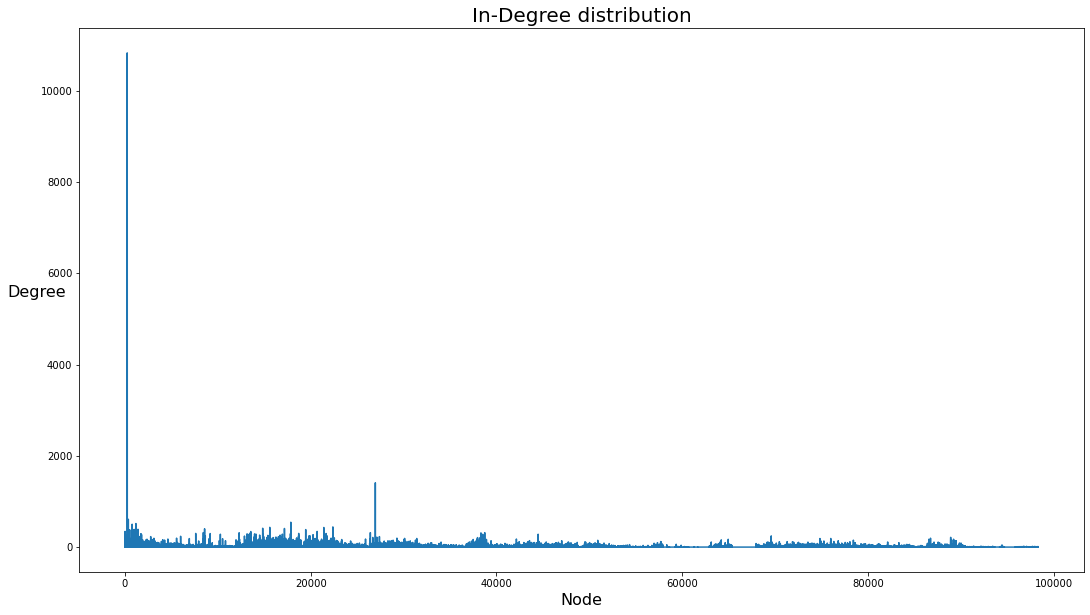

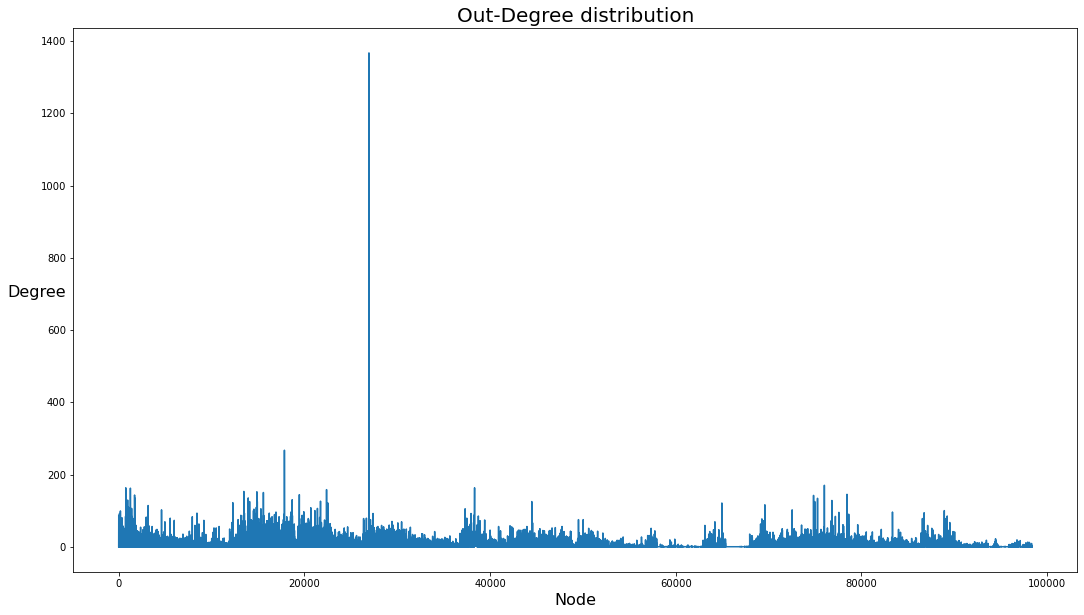

In [15]:
# degree distrubution
plt.figure(figsize=(18,10))
plt.title("In-Degree distribution", fontsize=20)
plt.xlabel('Node', fontsize=16)
plt.ylabel('Degree', fontsize=16, rotation=360)
plt.plot(list(incoming_links.values()))

plt.figure(figsize=(18,10))
plt.title("Out-Degree distribution", fontsize=20)
plt.xlabel('Node', fontsize=16)
plt.ylabel('Degree', fontsize=16, rotation=360)
plt.plot(list(outgoing_links.values()))

## RQ2

The function __exploring__ take in input a page _v_ and a number of clcks _d_ and return a set of pages that user can reach in _d_ clicks from _v_.

In [16]:
# function to explore graph
def exploring(v, d):
    p = inverted_page_names[v]
    indices = {p}
    support_exploring(p, d, indices)
    return { page_names[i] for i in indices }

# support function for returning values
def support_exploring(v, d, ret):
    # v: page
    # d: number of clicks
    # g: input graph
    # r: return value
    if d == 0:
        return 
    for n in graph.neighbors(v):
        ret.add(n)
        support_exploring(n, d-1, ret)

In the next cell there is a sample of function execution with inputs:
- page: 'This Way (Hana Pestle album)';
- number of clicks: 3.

And after that another one with inputs:
- page: "Marty O'Brien";
- number of clicks: 1.

In [17]:
exploring('This Way (Hana Pestle album)', 3)

{'22nd Century Lifestyle',
 'A Prairie Home Companion (film)',
 'A Rhyme & Reason',
 'Aaron Carter',
 'Alanis Morissette',
 'Alessandra Stanley',
 'Ali Lohan',
 'Andy Dick',
 'Andy Johns',
 'Ann-Margret',
 'Bette Midler',
 'Betty Hutton',
 'Bill Cosby',
 'Bill Duke',
 'Bobby (2006 film)',
 'Bowling for Columbine',
 'Britney Spears',
 'Bulworth',
 'Chazz Palminteri',
 'Chicago (2002 film)',
 'Christina Aguilera',
 'Christina Ricci',
 'Confessions of a Teenage Drama Queen',
 'Cover (film)',
 'Cursed (2005 film)',
 'Cyd Charisse',
 'Cyndi Lauper',
 'Danielle Brisebois',
 'Dead Man on Campus',
 'Deep Throat (film)',
 'Dennis Quaid',
 'Detroit Rock City (film)',
 'Dina Lohan',
 'Dirty Dancing: Havana Nights',
 'Dolly Parton',
 'Donny Osmond',
 'Dwayne Johnson',
 'Emilio Estevez',
 'Eminem',
 'Evan Rachel Wood',
 'Felicity Huffman',
 'Freaky Friday (2003 film)',
 'Fred Astaire',
 'From Hell (film)',
 'From Justin to Kelly',
 'Gamer (film)',
 'Gene Kelly',
 'Georgia Rule',
 'Get a Clue',
 'Ha

In [18]:
exploring("Marty O'Brien", 1)

{'22nd Century Lifestyle',
 'A Rhyme & Reason',
 'Kelly Clarkson',
 'Lindsay Lohan',
 'Ma',
 'Marilyn Manson',
 "Marty O'Brien"}

In the next cells there are an iterative version of __exploring__ function and its prove.

In [19]:
def iterative_exploring(v, d):
    # v: start node
    v = inverted_page_names[v]
    i = 0
    neighbors = [v]
    indices = [v]

    while i < d:
        prev_neighbors = neighbors
        neighbors = []
        for x in prev_neighbors:
            neighbors.extend(graph.neighbors(x))
        indices.extend(neighbors)
        i += 1

    return { page_names[i] for i in indices }

In [20]:
iterative_exploring("Marty O'Brien", 1)

{'22nd Century Lifestyle',
 'A Rhyme & Reason',
 'Kelly Clarkson',
 'Lindsay Lohan',
 'Ma',
 'Marilyn Manson',
 "Marty O'Brien"}

## RQ3

To find  the minimum number of clicks required to reach all pages in _p_, starting from the page _v_, corresponding to the most central article we have cretae two support fucntion:
- __cenral_article__, that search the central article for a category
- __compute_node_distances__, that returns a dictionary with the distances from input node to all others

In [21]:
# Find the cenatral page in a category
def central_article(c):
    # c: category
    
    degree = dict(graph.degree)
    
    v = None
    d = 0
    for node in categories[c]:
        if degree[node] >= d:
            v = node
            d = degree[node]
    # return node with max in-degree for category c
    return v

# support function: compute distance from a node u to all nodes in graph
def compute_node_distances(u):
    # u: start node; a node of graph
    
    # keep track of explored nodes and their distances
    explored = {}    
    explored[u] = 0
    
    # keep track of all the paths to be checked
    queue = [u]
    
    # keeps looping until all possible paths have been checked
    while queue:
        # pop the first path from the queue
        node = queue.pop(0)
            # go through all neighbour nodes, store their distances
            # push them into the queue
        for neighbour in graph.neighbors(node):
            if neighbour not in explored:
                explored[neighbour] = explored[node] + 1
                queue.append(neighbour)
    
    return explored

In [22]:
print("This is an example of central article", '"'+page_names[central_article('Burton Albion F.C. players')]+'"')

This is an example of central article "Bertie Mee"


The requested function is the following.

In [23]:
def minimum_path(c, pages):
    
    distance = [[0]]
    queue = [[central_article(c)]]
 
    # keeps looping until all possible paths have been checked
    while queue:
        # pop the first path from the queue
        path = queue.pop(0)
        ds = distance.pop(0)
        # get the last node from the path
        node = path[-1]
        d = ds[-1]
        # compute distance from node
        dist = compute_node_distances(node)
        dist = {k: v for k, v in sorted(dist.items(), key=lambda item: item[1])}
        for n in dist:
            if n in (pages - set(path)):
                new_path = list(path)
                new_ds = list(ds)
                new_path.append(n)
                new_ds.append(dist[n] + d)
                queue.append(new_path)
                distance.append(new_ds)
                # return path if node is goal
                if set(new_path) == pages:
                    return new_ds[-1] # return the minimum path distance checked
 
    # in case there's no path between the all nodes
    return "Not possible"

In [24]:
print('''The distances between 'Eli Lilly and Company's category is''', minimum_path('Eli Lilly and Company', set(categories['Eli Lilly and Company'])))

NetworkXError: The node None is not in the digraph.

In [ ]:
print("This is an example with a no path between pages --> ",\
      minimum_path('People from Tehran', set(categories['People from Tehran'])))

## RQ4

The function __double_cat_subg__ returns a subgraph with the nodes and the edges corrispondent with the nodes present in the two categories.

The function __my_double_cat_subg__ has an implementation from scratch of the function subgraph of networkx library.

The result of the two function is the same.

In [25]:
def double_cat_subg(c1, c2):
    # c1: category 1
    # c2: category 2
    cat_nodes = set(categories[c1]) | set(categories[c2]) # the set of all possible nodes
    cat_nodes = cat_nodes & set(graph.nodes) # clean the node
    return graph.subgraph(cat_nodes)

In [26]:
def my_double_cat_subg(c1, c2):
    # c1: category 1
    # c2: category 2
    cat_nodes = set(categories[c1]) | set(categories[c2]) # the set of all possible nodes
    cat_nodes = cat_nodes & set(graph.nodes) # clean the node
    sg = nx.DiGraph()
    sg.add_nodes_from((n, graph.nodes[n]) for n in cat_nodes)
    sg.add_edges_from((n, nbr, d) for n, nbrs in graph.adj.items() if n in cat_nodes\
                      for nbr, d in nbrs.items() if nbr in cat_nodes)
    return sg

The function below find the best path between two nodes _u_ and _v_.

In [27]:
# finds shortest path between 2 nodes of a graph using BFS
def bfs_shortest_path(u, v, g):
    # u: start node
    # v: goal node
    # g: graph
    
    # keep track of explored nodes
    explored = []
    # keep track of all the paths to be checked
    queue = [[u]]
 
    # return path if start is goal
    if u == v:
        return "Exception: u and v are the same node" # no path! the nodes are the same
 
    # keeps looping until all possible paths have been checked
    while queue:
        # pop the first path from the queue
        path = queue.pop(0)
        # get the last node from the path
        node = path[-1]
        if node not in explored:
            # go through all neighbour nodes, construct a new path and
            # push it into the queue
            for neighbour in g.neighbors(node):
                new_path = list(path)
                new_path.append(neighbour)
                queue.append(new_path)
                # return path if neighbour is goal
                if neighbour == v:
                    return new_path
 
            # mark node as explored
            explored.append(node)
 
    # in case there's no path between the 2 nodes
    return "Not possible"

In the cell below there is an example of the previous two functions.

For randomized the output use the __sammple__ function. It returns two nodes with two different categories.

In [28]:
def sample():
    # g: graph on doing sample
    edges = list(graph.edges) # list of edges
    # initialize return's values
    edge = 0
    cat1 = ''
    cat2 = ''
    # find a solution
    while cat1 == cat2:
        edge = edges[np.random.choice(len(edges), 1)[0]]
        cat1 = page_category[edge[0]]
        cat2 = page_category[edge[1]]
    # return nodes and relative categories
    return edge[0], edge[1], cat1, cat2

In [29]:
print("An example of sample function is the next one.\n")
s = sample()
print(s)

An example of sample function is the next one.

(1061969, 1060299, 'People from Brooklyn', 'American voice actors')


In [30]:
# run on s sample
sg = my_double_cat_subg(s[2], s[3])
print("The subgraph is composed by", '''"'''+s[2]+'''"''', "and", '''"'''+s[3] + '".')
print( "That is an example of shortest path returned with two random nodes:", s[0], s[1], " -->", bfs_shortest_path(s[0], s[1], sg))

The subgraph is composed by "People from Brooklyn" and "American voice actors".
That is an example of shortest path returned with two random nodes: 1061969 1060299  --> [1061969, 1060299]


The function below find the lenght of the minimum set of hyperlinks one can remove to disconnect _u_ and _v_.

In [31]:
def min_cut_subg(c1, c2, u, v):
    # c1: category 1
    # c2: category 2
    # u: start node
    # v: goal node
    sg = my_double_cat_subg(c1, c2)
    count = 0
    loop = True
    n1 = inverted_page_names[u]
    n2 = inverted_page_names[v]
    while loop:
        path = bfs_shortest_path(n1, n2, sg)
        if type(path) is str:
            loop = False
        else:
            count += 1
            removing = [ (path[i-1], path[i] ) for i in range(1, len(path)) ]
            for edge in removing:
                sg.remove_edge(*edge)
    return count

An example of function excution on the categories and the nodes of the previous example.

In [32]:
print("The nodes of the previous example are:", '"'+page_names[s[0]]+'"', "and", '"'+page_names[s[1]]+'".')

print("The lenght of minimum set of hyperlinks one can remove to disconnect u and v is", min_cut_subg(s[2], s[3], page_names[s[0]], page_names[s[1]]))

The nodes of the previous example are: "Richard Dreyfuss" and "Elizabeth Berkley".
The lenght of minimum set of hyperlinks one can remove to disconnect u and v is 1


In the next first two cells there are two support function for the __min_cut_subg_set__.
It finds he minimum set of hyperlinks one can remove to disconnect the nodes _u_ and _v_.

In [33]:
def sublists(l):
    # l: input list
    
    # list to store all the sublists 
    sublist = [] 
    for i in range(len(l) + 1): 
        for j in range(i + 1, len(l) + 1): 
            sli = l[i:j]  # make a slice of the subarray 
            sublist.append(sli) #add it to the list of sublists
    # sort list in order with the len of sublist
    sublist.sort(key=len)
    return sublist 

In [34]:
def connected(u, v, g):
    # u: start node
    # v: goal node
    # g: graph
    
    # keep track of explored nodes
    explored = []
    # keep track of all the nodes to be checked
    queue = [u] 
    if u == v:
        return None # no connection! the nodes are the same
    # keeps looping until all possible paths have been checked
    while queue:
        node = queue.pop(0)
        if node not in explored:
            for neighbour in g.neighbors(node):
                queue.append(neighbour)
                # return path if neighbour is goal
                if neighbour == v:
                    return True # there is a path!
            # mark node as explored
            explored.append(node)
    # in case there's no path between the 2 nodes
    return False

In [35]:
def min_cut_subg_set(c1, c2, u, v):
    # c1: category 1
    # c2: category 2
    # u: start node
    # v: goal node
    
    sg = my_double_cat_subg(c1, c2) # set subgraph
    loop = True
    n1 = inverted_page_names[u]
    n2 = inverted_page_names[v]
    
    removed = [] # the lit of edges removed
    while loop:
        path = bfs_shortest_path(n1, n2, sg)
        if type(path) is not str:
            r = [ (path[i-1], path[i] ) for i in range(1, len(path)) ]
            removing = sublists(r)
            # check wich set of edges doing disconnection
            for edgelist in removing:
                g = nx.Graph(sg)
                for edge in edgelist:
                    g.remove_edge(*edge)
                if not connected(n1, n2, g):
                    removed += edgelist
                    # return the correct set of edges
                    return { (page_names[edge[0]], page_names[edge[1]]) for edge in set(removed) }
            # repeat loop with new graph    
            for edge in r:
                sg.remove_edge(*edge)
            removed += r
        else:
            loop = False
    return { (page_names[edge[0]], page_names[edge[1]]) for edge in set(removed) }

An example of execution.

In [36]:
print("Below there is the set of hyperlinks could be removed to disconnect.\n", '- "'+page_names[s[0]]+'"\n', '- "'+page_names[s[1]]+'".\n')
print(min_cut_subg_set(s[2], s[3], page_names[s[0]], page_names[s[1]]))

Below there is the set of hyperlinks could be removed to disconnect.
 - "Richard Dreyfuss"
 - "Elizabeth Berkley".

{('Richard Dreyfuss', 'Elizabeth Berkley')}


## RQ5

For this question we assume that *the set of shortest paths* is a set composed by the lengher of shortest path from each pair of nodes in the two categories.

In the next cells there is a support function for __other_categories__ one. It uses also the __compute_node_distances__ function.

In [37]:
# support function for search median in an ordered list
median = lambda l : int((l[len(l)//2] + l[~(len(l)//2)]) / 2)

__other_categories__ function returns the list of remaning categories sorted by their distance from *c* input category.

In [38]:
def other_categories(c):
    # c: category
    
    # calculate shortestpath set and relative median value
    
    #calculate set of shortest path
    set_dist = defaultdict(set)
    
    #for each node of c calculate distance
    for node in categories[c]:
        dist = compute_node_distances(node)
        # for n node and v value of distance add value to respective set
        for n, v in dist.items():
            set_dist[page_category[n]].add(v)
            
    # clean set_dist and delete c if is in it
    try:
        del set_dist[c]
    except:
        pass
    
    # compute the median of all set_dist
    all_cat = list(set_dist.keys())
    distances = []
    for cat in all_cat:
        # append the median distance
        distances.append(median(sorted(list(set_dist[cat]))))
        
    # sort categories by distances
    all_cat = [x for _, x in sorted(zip(distances, all_cat))]
    return all_cat

In the next cell there is an example of execution for category _"Burton Albion F.C. players"_

In [39]:
other_categories('Burton Albion F.C. players')

['1974 FIFA World Cup players',
 '2002 African Cup of Nations players',
 'Dutch people of Surinamese descent',
 'Eerste Divisie players',
 'English Football Hall of Fame inductees',
 'English football chairmen and investors',
 'Expatriate footballers in Malaysia',
 'FIFA Confederations Cup-winning players',
 'Levante UD footballers',
 'Los Angeles Galaxy players',
 'Members of the Order of the British Empire',
 'People from Scarborough, North Yorkshire',
 'Santos Futebol Clube players',
 'UEFA Euro 1992 players',
 '1930 FIFA World Cup players',
 '1954 FIFA World Cup players',
 '1962 FIFA World Cup players',
 '1966 FIFA World Cup players',
 '1970 FIFA World Cup players',
 '1978 FIFA World Cup players',
 '1982 FIFA World Cup players',
 '1999 Copa Amrica players',
 '2000 AFC Asian Cup players',
 '2003 FIFA Confederations Cup players',
 'A.S. Livorno Calcio players',
 'AJ Auxerre players',
 'APOEL F.C. players',
 'Alloa Athletic F.C. players',
 'Alumni of Birkbeck, University of London',
 

## RQ6

The function __out_weighted_graph__ return a networkx graph equal to the __stochastic_graph__ library's function.

In [167]:
def out_weighted_graph(g=graph):
    n = nx.DiGraph()
    for edge in g.edges:
        w = g.get_edge_data(*edge)['weight'] / g.out_degree(edge[0])
        n.add_edge(edge[0], edge[1], weight=w)
    return n

The next cell contains the _PageRank_ implementation.

In [166]:
def page_rank(g=graph, max_it=100, d_fact=0.85, tol=0.000001, verbose=True):
    # g: a networkx graph with some nodes and edges
    
    # create a right stocastic graph from g
    # it's the equivalent operation of the next commented one
    # g = nx.stochastic_graph(g, weight='weight')
    g = out_weighted_graph(g) 
    # save number of nodes
    n_nodes = g.number_of_nodes()
    # create a starting vector
    x = dict.fromkeys(g, 1.0 / n_nodes)
    # Assign uniform personalization vector
    p = dict.fromkeys(g, 1.0 / n_nodes)
    # compute dangling nodes
    dangling_nodes = [n for n in g if g.out_degree(n, weight='weight') == 0.0]
    
    # power iteration: make up to max_iter iterations 
    for i in range(max_it): 
        xlast = x 
        x = dict.fromkeys(xlast.keys(), 0) 
        danglesum = d_fact * sum(xlast[n] for n in dangling_nodes) 
        for n in x: 
            # this matrix multiply looks odd because it is 
            # doing a left multiply x^T = xlast^T * W 
            for nbr in g[n]: 
                x[nbr] += d_fact * xlast[n] * g[n][nbr]['weight'] 
            x[n] += danglesum * p[n] + (1.0 - 0.85) * p[n]
        # check convergence
        err = sum([abs(x[n] - xlast[n]) for n in x])
        if err < n_nodes*tol:
            if verbose: print("PageRank algorithm converges after",
                              i, "iterations with tollerance value set to",
                              str(tol)+'.')
            return x
    # raise that the number of iterations isn't good
    return str(max_it) + "iterations are not enough to be under the tolerance limit."

For the final result we can assumed that the final value of PageRank for each category is the sum of respective node's values starting from the all graph.

Another approach is prodcue the page rank for each category's subgraph and report it.

_N.B.: For a readble output are printed only the top 10 category for each approach._

In [195]:
# first approach

cat_ranking = list()
pr = page_rank()
for category, pages in categories.items():
    # calculate category value from page's value
    value = 0
    for page in pages:
        value += pr[page]
    cat_ranking += [(category, value)]
# store in a dataframe
cat_ranking = pd.DataFrame(cat_ranking, columns=['Category', 'PageRank value'])\
                .sort_values(by='PageRank value', ascending=False)
print('\n\nCategories Ranking\n'+ cat_ranking.head(10).to_string(index=False))

PageRank algorithm converges after 5 iterations with tollerance value set to 1e-06.


Categories Ranking
                             Category  PageRank value
                  Main Belt asteroids        0.076496
                 American film actors        0.039154
                        Living people        0.037197
               English-language films        0.029945
                    Rivers of Romania        0.029005
           American television actors        0.022428
                       American films        0.022209
 Asteroids named from Greek mythology        0.014825
                Black-and-white films        0.011432
           Asteroids named for people        0.011175


In [ ]:
# secomd approach

# TODO